In [9]:
# os モジュールはファイルパス操作やディレクトリ操作などのOS依存の処理に使用する
import os

# copy モジュールはオブジェクトの浅いコピー・深いコピーを行うために使用する
import copy

# string モジュールは文字列操作に関する定数（アルファベットなど）を提供する
import string

# tqdm モジュールはイテレーションの進捗状況をプログレスバーで表示するライブラリ
from tqdm import tqdm

# NumPy は数値計算用のライブラリで、多次元配列や数学関数を提供する
import numpy as np

# PyTorch のメインライブラリ。テンソル操作やニューラルネットワークの定義に使用される
import torch

# データセットの一部を抽出する Subset、分割する random_split、複数結合する ConcatDataset などを提供
from torch.utils.data import Subset, DataLoader, random_split, ConcatDataset

# ニューラルネットワーク構造を定義するためのモジュール
import torch.nn as nn

# 活性化関数などを含む PyTorch の関数モジュール（F.relu など）
import torch.nn.functional as F

# 最適化アルゴリズム（SGD, Adam など）を提供するモジュール
import torch.optim as optim

# torchvision は PyTorch 用の画像処理ライブラリで、データセット・モデル・変換を提供
import torchvision

# torchvision.transforms は画像前処理（正規化、リサイズ、テンソル変換など）を行うためのモジュール
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

import seaborn as sns

In [2]:
# ===============================
# 環境準備と設定
# ===============================


# 乱数シードを固定する関数（再現性を確保するため）
def set_seed(seed):
    np.random.seed(seed)  # NumPyの乱数シードを設定
    torch.manual_seed(seed)  # CPUでのPyTorchの乱数シードを設定
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)  # CUDA（GPU）での乱数シードを設定
        torch.cuda.manual_seed_all(seed)  # 複数GPU環境でもすべてに適用
    # 以下2行は、cuDNNの非決定的な挙動を制限して結果の再現性を高める設定
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


# シード値を固定
set_seed(42)

# 学習・推論に使用するデバイス（GPUが利用可能ならGPU、そうでなければCPU）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# データとモデルの保存先ディレクトリのパス設定
data_dir = "../data"
model_dir = "../model"

# モデル保存ディレクトリを作成（すでに存在していればスキップ）
os.makedirs(model_dir, exist_ok=True)


# ===============================
# データの前処理と読み込み
# ===============================

# 画像をTensor型に変換し、[0,1] → [-1,1] に正規化する
transform = transforms.Compose(
    [
        transforms.ToTensor(),  # 画像をTensorに変換
        transforms.Normalize(
            (0.5,), (0.5,)
        ),  # 平均0.5, 標準偏差0.5で正規化（1チャネル）
    ]
)

# MNISTの訓練データセットをダウンロード＆前処理
trainset = torchvision.datasets.MNIST(
    root=data_dir, train=True, download=True, transform=transform
)

# MNISTのテストデータセットをダウンロード＆前処理
testset = torchvision.datasets.MNIST(
    root=data_dir, train=False, download=True, transform=transform
)

# バッチサイズの設定
batch_size = 100

# テストデータセットを検証用とテスト用にランダムに半分ずつ（5000ずつ）に分割
valtest_set_list = random_split(testset, [5000, 5000])

# 検証用・テスト用データローダーを生成（バッチ単位でデータを供給）
valloader, testloader = [
    DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    for dataset in valtest_set_list
]


# ===============================
# ネットワーク構造の定義
# ===============================


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 入力：28×28=784ピクセル → 全結合層（400ユニット）
        self.fc1 = nn.Linear(28 * 28, 400)
        # 第2層：400ユニット → 200ユニット
        self.fc2 = nn.Linear(400, 200)
        # 第3層：200ユニット → 100ユニット
        self.fc3 = nn.Linear(200, 100)
        # 出力層：100ユニット → 10クラス分類（0～9）
        self.fc4 = nn.Linear(100, 10)

    def forward(self, x):
        # 画像を1次元（バッチサイズ × 784）に変形（flatten）
        x = x.view(-1, 28 * 28)
        # ReLU活性化関数を通す（非線形変換）
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        # 最終出力（ソフトマックスは使わずロジットのまま）
        x = self.fc4(x)
        return x


# ===============================
# モデルの評価（テスト）関数
# ===============================


def test(net, dataloader, device="cpu", criterion=nn.CrossEntropyLoss()):
    """
    指定されたモデルとデータローダを用いて損失と精度を評価する関数。
    """
    with torch.no_grad():  # 勾配を追跡しない（メモリ・計算効率向上）
        running_loss = 0  # 累積損失
        correct_preds = 0  # 正解数
        total_preds = 0  # 総予測数

        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)  # デバイスに転送
            outputs = net(inputs)  # モデルの出力（ロジット）
            loss = criterion(outputs, labels)  # 損失計算（クロスエントロピー）

            running_loss += loss.item()  # 損失を加算
            correct_preds += outputs.max(1)[1].eq(labels).sum().item()  # 正解数を加算
            total_preds += outputs.size(0)  # バッチ数を加算

        # 平均損失と精度（％）を計算
        loss = running_loss / len(dataloader)
        acc = 100 * correct_preds / total_preds
    return loss, acc


# ===============================
# クライアント名の自動生成関数
# ===============================


def gen_clients_list(n):
    """
    クライアント数 n に応じて A, B, ..., Z, AA, AB, ..., などの名前を生成する関数。
    Excelの列名のような生成規則に基づく。
    """
    alphabet = string.ascii_uppercase  # 'A'〜'Z'
    result = []
    for i in range(n):
        sequence = ""
        idx = i
        while idx >= 0:
            # アルファベットを逆順に組み立てる
            sequence = alphabet[idx % 26] + sequence
            idx = idx // 26 - 1
        result.append(sequence)
    return result

In [3]:
# ===============================
# クライアント（Client）クラスの定義
# ===============================


class Client:
    def __init__(self, client_name, dataloader, device="cpu"):
        """
        クライアントの初期化処理。
        各クライアントはデータローダとモデルを持ち、学習・送受信を担当する。
        """
        self.name = client_name  # クライアント名（例："A"）
        self.filename = (
            f"client_{self.name}_model.pth"  # このクライアントのモデル保存ファイル名
        )
        self.dataloader = dataloader  # クライアントが保持するローカルデータ
        self.num_data = len(
            self.dataloader.dataset
        )  # データ数（学習時の重み付けに使う）

        self.device = device  # 実行デバイス（CPU/GPU）

        self.set_model()  # モデルを初期化

    def set_model(self, net=None, criterion=nn.CrossEntropyLoss(), lr=0.02):
        """
        モデルを初期化または外部から受け取ったモデルで設定する関数。
        - net: 外部から受け取ったモデル（省略時は新規作成）
        - criterion: 損失関数（デフォルト：クロスエントロピー）
        - lr: 学習率（デフォルト：0.02）
        """
        if net != None:
            self.net = net  # 渡されたモデルを使用
        else:
            self.net = Net().to(self.device)  # 新規モデルを生成してデバイスに転送

        self.lr = lr  # 学習率の保存
        self.criterion = criterion  # 損失関数の保存
        self.optim = optim.SGD(self.net.parameters(), lr=self.lr)  # SGD最適化器を生成

    def train(self, n_epochs=1):
        """
        クライアントが自身のローカルデータで n_epochs 回学習を行う関数。
        学習後、損失と精度を表示する。
        """
        running_loss = 0  # 累積損失
        correct_preds = 0  # 正解数
        total_preds = 0  # 総データ数

        for _ in range(n_epochs):
            for inputs, labels in self.dataloader:
                # データを指定されたデバイス（CPU/GPU）に転送
                inputs, labels = inputs.to(self.device), labels.to(self.device)

                # 勾配の初期化 → 順伝播 → 損失計算 → 逆伝播 → パラメータ更新
                self.optim.zero_grad()
                outputs = self.net(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optim.step()

                # 統計情報の記録
                running_loss += loss.item()
                correct_preds += outputs.max(1)[1].eq(labels).sum().item()
                total_preds += outputs.size(0)

        # 学習結果の表示（平均損失と正解率）
        print(
            f"Client {self.name}, Training loss: {running_loss/len(self.dataloader):.3f} - Accuracy: {100*correct_preds/total_preds:.3f}"
        )

    def send_model(self):
        """
        学習済みのローカルモデルをローカルディレクトリに保存する。
        通信を模して model_dir にファイルを書き出す。
        """
        torch.save(self.net.state_dict(), os.path.join(model_dir, self.filename))

    def load_model(self, model_name="agg_model.pth"):
        """
        サーバー側で集約されたモデルを受け取り、自身のモデルに反映する関数。
        - model_name: サーバーから渡された集約済みモデルのファイル名
        """
        # 集約モデルを読み込み、state_dict（パラメータ辞書）を取得
        agg_mlp = torch.load(os.path.join(model_dir, model_name), weights_only=True)

        # 読み込んだパラメータを現在のネットワークにロード
        self.net.load_state_dict(agg_mlp)

        # デバイスへ転送し、最適化器も再生成
        self.net.to(device)
        self.optim = optim.SGD(self.net.parameters(), lr=self.lr)

In [4]:
# ===============================
# 中央サーバー（CentralServer）クラスの定義
# ===============================


class CentralServer:
    def __init__(self, data_num_dict):
        """
        初期化処理：
        - 各クライアントが保持しているデータ数を記録（重み付き平均の計算に使用）
        - クライアントから受け取ったモデルを格納する辞書や、集約済みモデルを格納する変数を初期化
        """
        self.client_model_dict = None  # クライアント名 → モデルの state_dict の辞書
        self.agg_net = None  # 集約済みのモデル（Netインスタンス）
        self.client_datanum_dict = (
            data_num_dict  # 各クライアントのデータ数（モデル重み用）
        )

    def aggregate(self, net=Net()):
        """
        クライアントから受け取ったモデルを、FedAvg（重み付き平均）で集約する関数。
        - net: ネットワーク構造をコピーするための基準モデル（デフォルトで新規Net）
        """
        self.receive_model()  # クライアントのモデルを読み込む
        self.agg_net = copy.deepcopy(
            net
        )  # ネットワーク構造をコピー（パラメータはまだ反映しない）

        layer_list = (
            self.agg_net.state_dict().keys()
        )  # 集約対象となるレイヤー名のリスト（パラメータ名）

        # 各レイヤーごとに重み付き平均を計算し、agg_params に格納
        agg_params = {
            layer: torch.sum(
                torch.stack(
                    [
                        self.client_model_dict[filename][layer]
                        * self.client_datanum_dict[filename]
                        for filename in self.client_datanum_dict.keys()
                    ]
                ),
                dim=0,
            )
            / sum(self.client_datanum_dict.values())  # データ数の合計で割る（平均化）
            for layer in layer_list
        }

        # 平均化されたパラメータをモデルにロードする
        self.agg_net.load_state_dict(agg_params)
        self.agg_net.to(device)  # デバイス（GPU or CPU）に転送

    def receive_model(self):
        """
        クライアントから送られてきたモデルをローカルディレクトリから読み込む関数。
        実際には通信ではなく、ローカルファイルからの読み込みで代用している。
        """
        self.client_model_dict = {
            filename: torch.load(os.path.join(model_dir, filename), weights_only=True)
            for filename in self.client_datanum_dict.keys()
        }

    def send_model(self):
        """
        集約したモデル（agg_net）をファイルに保存する関数。
        クライアントがこのファイルを読み込むことで「モデル受信」が実現される。
        """
        torch.save(self.agg_net.state_dict(), os.path.join(model_dir, "agg_model.pth"))

In [5]:
# ===============================
# クライアントとサーバーの初期化処理
# ===============================

n_clients = 3  # 学習に参加するクライアントの数（例：3台）

# クライアント名のリストを生成（例：["A", "B", "C"]）
clients_list = gen_clients_list(n_clients)

# 各クライアントが保持するデータの割合を指定（今回は等分：1/3ずつ）
clients_data_rate = [1 / n_clients] * n_clients

# MNISTの訓練データを、指定された割合でランダムに分割
clients_dataset_list = random_split(
    trainset,
    [
        int(rate * len(trainset)) for rate in clients_data_rate
    ],  # [20000, 20000, 20000] など
)

# 各クライアント用のデータローダーを生成し、辞書に格納（キー：クライアント名）
clients_dataloader_dict = {
    key: DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    for key, dataset in zip(clients_list, clients_dataset_list)
}


# ===============================
# 各クライアントのインスタンスを生成
# ===============================

clients_dict = {
    # クライアント名をキーとして、Clientインスタンスを辞書に格納
    client_name: Client(client_name, dataloader, device=device)
    for client_name, dataloader in clients_dataloader_dict.items()
}


# ===============================
# 中央サーバーのインスタンスを生成
# ===============================

# 各クライアントが保持するデータ数をキーにしてサーバーに渡す
# → aggregate() での重み付き平均の計算に利用される
server = CentralServer(
    data_num_dict={client.filename: client.num_data for client in clients_dict.values()}
)

====round:0====
----train----
Client A, Training loss: 2.130 - Accuracy: 38.795
Client B, Training loss: 2.101 - Accuracy: 36.755
Client C, Training loss: 2.084 - Accuracy: 35.760
----aggregate----
Validation, loss: 2.284 - Accuracy: 9.920
Replace Best Model

====round:1====
----train----
Client A, Training loss: 2.121 - Accuracy: 31.135
Client B, Training loss: 2.116 - Accuracy: 31.125
Client C, Training loss: 2.119 - Accuracy: 32.010
----aggregate----
Validation, loss: 1.689 - Accuracy: 44.040
Replace Best Model

====round:2====
----train----
Client A, Training loss: 1.201 - Accuracy: 60.220
Client B, Training loss: 1.195 - Accuracy: 60.300
Client C, Training loss: 1.191 - Accuracy: 60.630
----aggregate----
Validation, loss: 0.810 - Accuracy: 74.160
Replace Best Model

====round:3====
----train----
Client A, Training loss: 0.769 - Accuracy: 74.535
Client B, Training loss: 0.763 - Accuracy: 74.295
Client C, Training loss: 0.759 - Accuracy: 75.065
----aggregate----
Validation, loss: 0.

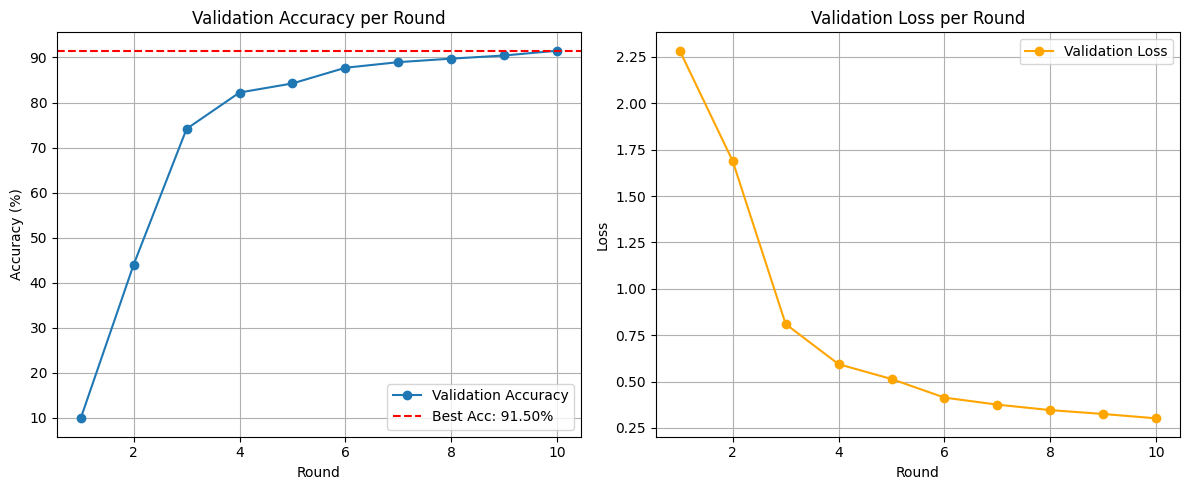

In [6]:
import matplotlib.pyplot as plt

# ===============================
# 連合学習のラウンド実行処理
# ===============================

n_round = 10  # 学習ラウンドの総数（＝通信回数）

best_acc = 0  # 検証精度の最高値を記録
best_model = None  # 現時点で最も良いモデルの保存用

val_acc_list = []  # 各ラウンドの検証精度を記録
val_loss_list = []  # 各ラウンドの検証損失を記録

# ===== 学習ループ開始 =====
for round in range(n_round):
    print(f"====round:{round}====")
    print(f"----train----")

    # === 各クライアントでローカル学習 → モデルをサーバーに送信 ===
    for client in clients_dict.values():
        client.train()  # ローカルデータで1エポック学習
        client.send_model()  # 学習後モデルをサーバーへ送信（ローカル保存）

    print(f"----aggregate----")

    # === サーバーがモデルを集約（FedAvg）===
    server.aggregate()
    server.send_model()

    # === 集約済みモデルでバリデーション評価 ===
    val_loss, val_acc = test(server.agg_net, valloader, device=device)
    print(f"Validation, loss: {val_loss:.3f} - Accuracy: {val_acc:.3f}")

    # 評価値を記録
    val_acc_list.append(val_acc)
    val_loss_list.append(val_loss)

    # === 最良モデルの更新チェック ===
    if val_acc > best_acc:
        best_acc = val_acc
        best_model = copy.deepcopy(server.agg_net)
        print("Replace Best Model")

        # クライアントに最良モデルを配布
        for client in clients_dict.values():
            client.load_model()

    print()


# ===============================
# 最終テスト評価
# ===============================

test_loss, test_acc = test(best_model, testloader, device=device)
print(f"Test, loss: {test_loss:.3f} - Accuracy: {test_acc:.3f}\n")


# ===============================
# グラフ描画（精度・損失の推移）
# ===============================

rounds = list(range(1, n_round + 1))

plt.figure(figsize=(12, 5))

# ---- 検証精度の推移 ----
plt.subplot(1, 2, 1)
plt.plot(rounds, val_acc_list, marker="o", label="Validation Accuracy")
plt.axhline(best_acc, color="red", linestyle="--", label=f"Best Acc: {best_acc:.2f}%")
plt.title("Validation Accuracy per Round")
plt.xlabel("Round")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)

# ---- 検証損失の推移 ----
plt.subplot(1, 2, 2)
plt.plot(rounds, val_loss_list, marker="o", label="Validation Loss", color="orange")
plt.title("Validation Loss per Round")
plt.xlabel("Round")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

========== Client : A ==========
====epoch:0====


Client A, Training loss: 2.057 - Accuracy: 41.050
Validation, loss: 1.402 - Accuracy: 64.600
Replace Best Model

====epoch:1====
Client A, Training loss: 0.882 - Accuracy: 75.355
Validation, loss: 0.576 - Accuracy: 82.720
Replace Best Model

====epoch:2====
Client A, Training loss: 0.522 - Accuracy: 84.125
Validation, loss: 0.421 - Accuracy: 87.260
Replace Best Model

====epoch:3====
Client A, Training loss: 0.417 - Accuracy: 87.635
Validation, loss: 0.350 - Accuracy: 89.900
Replace Best Model

====epoch:4====
Client A, Training loss: 0.375 - Accuracy: 88.950
Validation, loss: 0.362 - Accuracy: 89.320

====epoch:5====
Client A, Training loss: 0.341 - Accuracy: 90.000
Validation, loss: 0.299 - Accuracy: 91.260
Replace Best Model

====epoch:6====
Client A, Training loss: 0.318 - Accuracy: 90.765
Validation, loss: 0.283 - Accuracy: 91.880
Replace Best Model

====epoch:7====
Client A, Training loss: 0.297 - Accuracy: 91.445
Validation, loss: 0.274 - Accuracy: 91.960
Replace Best Model

===

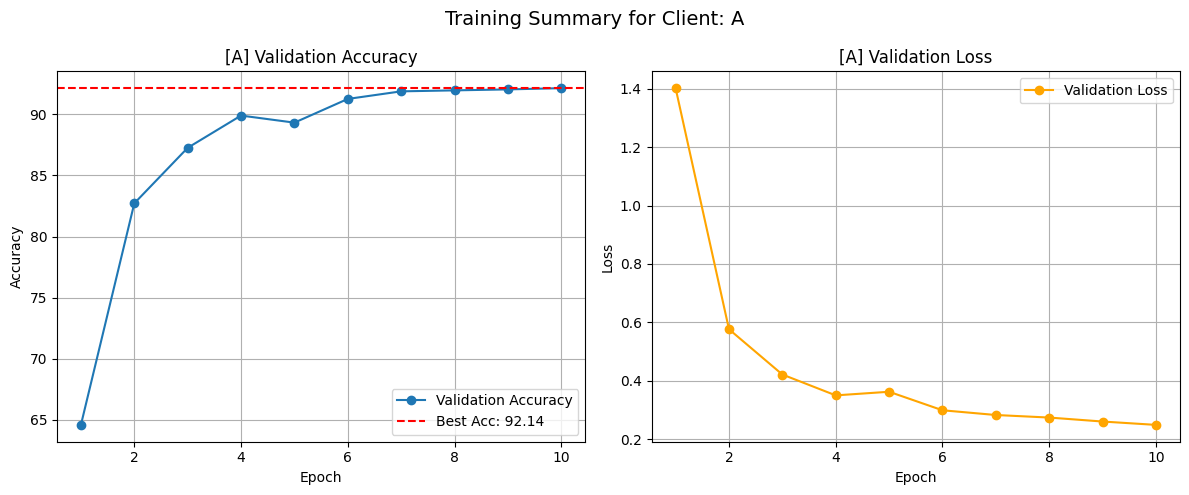

========== Client : B ==========
====epoch:0====
Client B, Training loss: 2.120 - Accuracy: 38.730
Validation, loss: 1.590 - Accuracy: 53.700
Replace Best Model

====epoch:1====
Client B, Training loss: 0.974 - Accuracy: 72.360
Validation, loss: 0.595 - Accuracy: 82.720
Replace Best Model

====epoch:2====
Client B, Training loss: 0.531 - Accuracy: 84.235
Validation, loss: 0.422 - Accuracy: 87.620
Replace Best Model

====epoch:3====
Client B, Training loss: 0.424 - Accuracy: 87.425
Validation, loss: 0.367 - Accuracy: 89.400
Replace Best Model

====epoch:4====
Client B, Training loss: 0.378 - Accuracy: 88.835
Validation, loss: 0.361 - Accuracy: 89.440
Replace Best Model

====epoch:5====
Client B, Training loss: 0.344 - Accuracy: 89.830
Validation, loss: 0.303 - Accuracy: 91.180
Replace Best Model

====epoch:6====
Client B, Training loss: 0.316 - Accuracy: 90.730
Validation, loss: 0.295 - Accuracy: 91.420
Replace Best Model

====epoch:7====
Client B, Training loss: 0.296 - Accuracy: 91.35

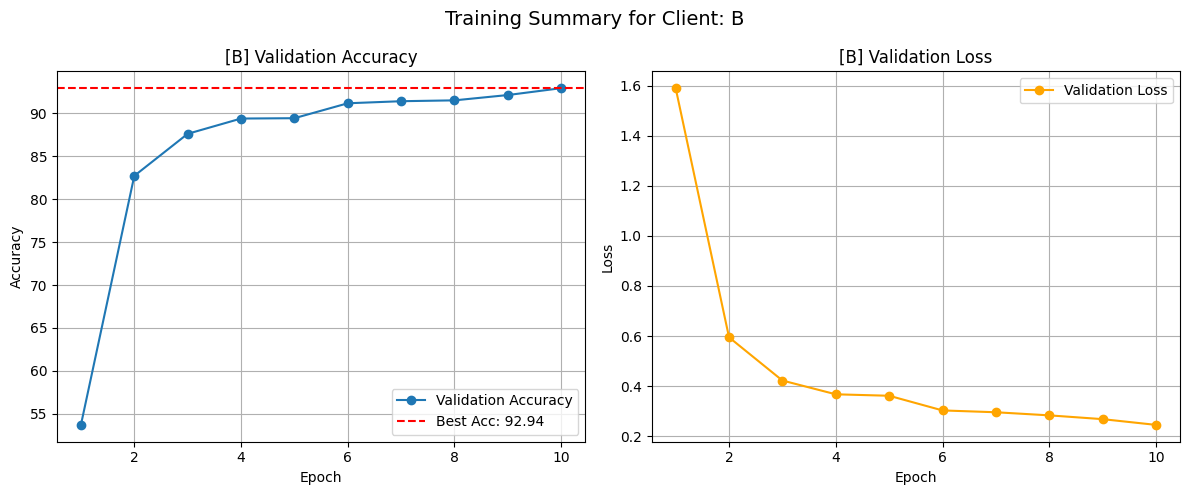

========== Client : C ==========
====epoch:0====
Client C, Training loss: 2.075 - Accuracy: 37.255
Validation, loss: 1.475 - Accuracy: 62.540
Replace Best Model

====epoch:1====
Client C, Training loss: 0.915 - Accuracy: 74.155
Validation, loss: 0.580 - Accuracy: 82.980
Replace Best Model

====epoch:2====
Client C, Training loss: 0.517 - Accuracy: 84.385
Validation, loss: 0.408 - Accuracy: 88.340
Replace Best Model

====epoch:3====
Client C, Training loss: 0.412 - Accuracy: 87.650
Validation, loss: 0.344 - Accuracy: 89.840
Replace Best Model

====epoch:4====
Client C, Training loss: 0.365 - Accuracy: 89.040
Validation, loss: 0.382 - Accuracy: 88.300

====epoch:5====
Client C, Training loss: 0.336 - Accuracy: 90.115
Validation, loss: 0.307 - Accuracy: 90.740
Replace Best Model

====epoch:6====
Client C, Training loss: 0.311 - Accuracy: 90.740
Validation, loss: 0.282 - Accuracy: 91.660
Replace Best Model

====epoch:7====
Client C, Training loss: 0.293 - Accuracy: 91.375
Validation, loss:

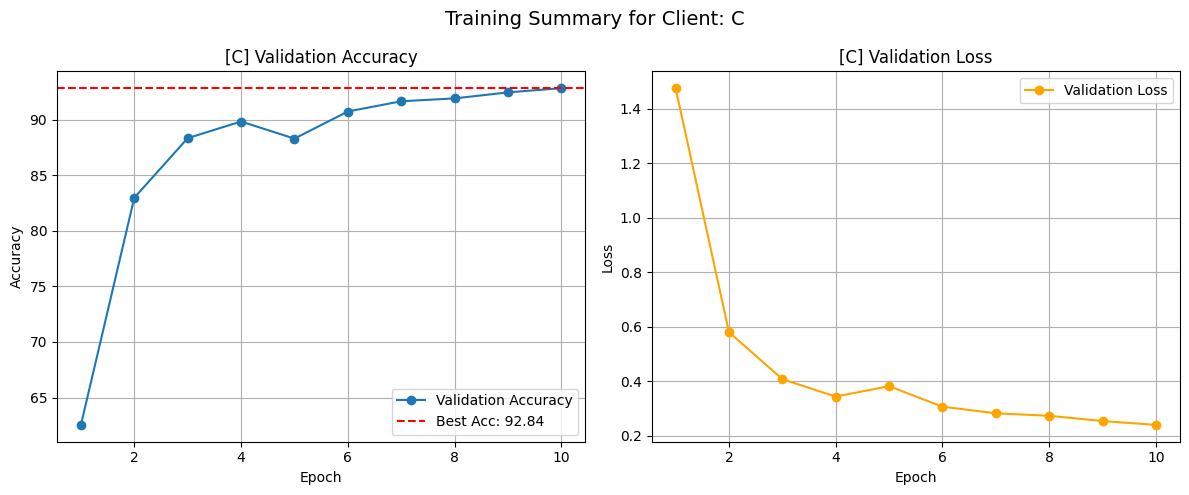

In [7]:
import matplotlib.pyplot as plt

# ===============================
# クライアントごとの単独学習実験（連合学習なし）
# ===============================

# 前の学習ループでクライアントのモデルが変わっているため、再初期化を行う
clients_dict = {
    client_name: Client(client_name, dataloader, device=device)
    for client_name, dataloader in clients_dataloader_dict.items()
}

epochs = 10  # 各クライアントが独自に学習するエポック数

# ===== 各クライアントでの単独学習を実施 =====
for client in clients_dict.values():
    best_acc = 0
    best_model = None
    val_acc_list = []  # バリデーション精度記録
    val_loss_list = []  # バリデーション損失記録

    print(f"========== Client : {client.name} ==========")

    for epoch in range(epochs):
        print(f"====epoch:{epoch}====")

        # クライアントでローカル学習を1エポック実行
        client.train()

        # バリデーションデータで検証を行う
        val_loss, val_acc = test(client.net, valloader, device=device)
        print(f"Validation, loss: {val_loss:.3f} - Accuracy: {val_acc:.3f}")

        # グラフ用データを保存
        val_acc_list.append(val_acc)
        val_loss_list.append(val_loss)

        # 現在のモデルが最高精度を更新した場合、保存する
        if val_acc > best_acc:
            best_acc = val_acc
            best_model = copy.deepcopy(client.net)
            print("Replace Best Model")

        print()  # 区切りの改行

    # 学習済み最良モデルでテストデータに対する評価を実施
    test_loss, test_acc = test(best_model, testloader, device=device)
    print(f"Test, loss: {test_loss:.3f} - Accuracy: {test_acc:.3f}")

    # ===============================
    # 学習推移のグラフ表示
    # ===============================

    epochs_range = list(range(1, epochs + 1))
    plt.figure(figsize=(12, 5))

    # 検証精度
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, val_acc_list, marker="o", label="Validation Accuracy")
    plt.axhline(
        best_acc, linestyle="--", color="red", label=f"Best Acc: {best_acc:.2f}"
    )
    plt.title(f"[{client.name}] Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)

    # 検証損失
    plt.subplot(1, 2, 2)
    plt.plot(
        epochs_range, val_loss_list, marker="o", label="Validation Loss", color="orange"
    )
    plt.title(f"[{client.name}] Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    plt.suptitle(f"Training Summary for Client: {client.name}", fontsize=14)
    plt.tight_layout()
    plt.show()

label:0, rate : [0.07504546 0.4475615  0.47739304]
label:1, rate : [0.30737399 0.42220718 0.27041883]
label:2, rate : [0.53575545 0.43819217 0.02605238]
label:3, rate : [0.13908355 0.04051557 0.82040088]
label:4, rate : [0.18165688 0.29388772 0.5244554 ]
label:5, rate : [0.17615008 0.28997689 0.53387302]
label:6, rate : [0.38419281 0.12926296 0.48654423]
label:7, rate : [0.08489623 0.48956209 0.42554168]
label:8, rate : [0.2743746  0.37749484 0.34813056]
label:9, rate : [0.11527548 0.55148275 0.33324177]


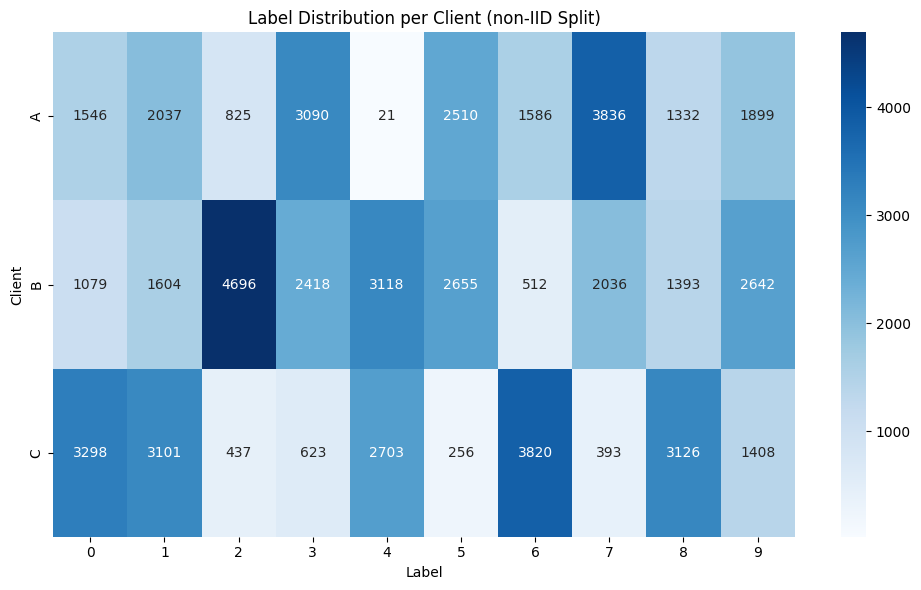

In [10]:
# ===============================
# ラベルごとに不均等な（non-IID）データ分割を行う処理
# ===============================

n_clients = 3  # クライアント数の指定
clients_list = gen_clients_list(n_clients)  # クライアント名のリスト（["A", "B", "C"]）

# 10行n_client列のランダム行列を生成（ラベル×クライアント）
# これは今回使用していないが、ラベルごとの分割割合を記録する用途に使える
split_rate_matrix = np.random.rand(10, n_clients)

# 各ラベルごとの割合が合計1になるように正規化（確率分布化）
row_sums = split_rate_matrix.sum(axis=1, keepdims=True)
normed_split_rate_matrix = split_rate_matrix / row_sums

# クライアントごとのデータセット格納用辞書を初期化（後でConcatDatasetするため None）
dataset_dict = {client_name: None for client_name in clients_list}


# ===== 各ラベルごとにデータをランダムに分割し、クライアントに割り当てる =====
for extract_label in range(10):
    # 各ラベルごとに、クライアントへの分配率（確率ベクトル）をランダムに生成
    rate_list = np.random.rand(n_clients)
    normed_rate_list = rate_list / rate_list.sum()  # 和が1になるように正規化
    print(f"label:{extract_label}, rate : {normed_rate_list}")

    # trainset から対象ラベルに該当するデータのインデックスだけを抽出
    indices = [i for i, (_, label) in enumerate(trainset) if extract_label == label]

    # 指定ラベルのデータだけを含む部分データセットを作成
    subset = Subset(trainset, indices)

    # 割合に従って subset をクライアント数に分割
    split_sizes = [int(rate * len(subset)) for rate in normed_rate_list]

    # 最後の要素に端数を加えて、合計サイズが一致するように調整
    split_sizes[-1] += len(indices) - sum(split_sizes)

    # データをクライアントごとの subset にランダムに分割
    split_subset = random_split(subset, split_sizes)

    # 各クライアントに割り当て（すでにデータがあれば結合）
    for i, client_name in enumerate(clients_list):
        if dataset_dict[client_name] is None:
            dataset_dict[client_name] = split_subset[i]
        else:
            # 複数のラベルにまたがる Subset を結合して1つのデータセットにする
            dataset_dict[client_name] = ConcatDataset(
                [dataset_dict[client_name], split_subset[i]]
            )


# ===============================
# データローダー・クライアント・サーバーの初期化
# ===============================

# 各クライアントごとのデータセットから DataLoader を作成
clients_dataloader_dict = {
    client_name: DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    for client_name, dataset in dataset_dict.items()
}

# 各クライアントのインスタンスを生成
clients_dict = {
    client_name: Client(client_name, dataloader, device=device)
    for client_name, dataloader in clients_dataloader_dict.items()
}

# 中央サーバーを生成し、クライアントごとのデータ数情報を渡す
server = CentralServer(
    data_num_dict={client.filename: client.num_data for client in clients_dict.values()}
)

# 各クライアントのラベル分布を集計する
label_distribution = np.zeros((n_clients, 10), dtype=int)  # shape: (client, label)

for label in range(10):
    indices = [i for i, (_, l) in enumerate(trainset) if l == label]
    rate_list = normed_split_rate_matrix[label]
    split_sizes = [int(rate * len(indices)) for rate in rate_list]
    split_sizes[-1] += len(indices) - sum(split_sizes)

    for i in range(n_clients):
        label_distribution[i, label] = split_sizes[i]

# ヒートマップを描画
plt.figure(figsize=(10, 6))
sns.heatmap(
    label_distribution,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=[str(i) for i in range(10)],
    yticklabels=clients_list,
)
plt.title("Label Distribution per Client (non-IID Split)")
plt.xlabel("Label")
plt.ylabel("Client")
plt.tight_layout()
plt.show()